<a href="https://colab.research.google.com/github/engineerksm/RF_Diagnosys_Dev/blob/master/GRU_LSTM_for_Fault_Prognostic_%5B1130%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# mount google drive to google colab

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/My Drive/Colab Notebooks/HAICON

/content/drive/My Drive/Colab Notebooks/HAICON


* Note that everytime you rerun

In [3]:
pip install eTaPR-1.12-py3-none-any.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./eTaPR-1.12-py3-none-any.whl
eTaPR is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [4]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr

In [5]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [6]:
torch.cuda.is_available()

True

**Data Preprocessing**

In [7]:
TRAIN_DATASET = sorted([x for x in Path("data/training/").glob("*.csv")])
TRAIN_DATASET

[PosixPath('data/training/train1.csv'),
 PosixPath('data/training/train2.csv'),
 PosixPath('data/training/train3.csv')]

In [8]:
TEST_DATASET = sorted([x for x in Path("data/testing/").glob("*.csv")])
TEST_DATASET

[PosixPath('data/testing/test1.csv'),
 PosixPath('data/testing/test2.csv'),
 PosixPath('data/testing/test3.csv'),
 PosixPath('data/testing/test4.csv')]

In [9]:
VALIDATION_DATASET = sorted([x for x in Path("data/validation/").glob("*.csv")])
VALIDATION_DATASET

[PosixPath('data/validation/validation.csv')]

In [10]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [11]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-11 00:00:00,395.19528,12,10,52.80456,-1.2648,-1.87531,779.59595,28.02645,10832.0,...,808.29620,0.0,1.36810,8.79882,35.43700,12.01782,305.03113,301.35992,33.6555,6.0951
1,2020-07-11 00:00:01,395.14420,12,10,52.78931,-1.3147,-1.88294,780.67328,28.02473,10984.0,...,819.16809,0.0,1.36810,8.78811,35.45227,12.01782,304.27161,297.43567,33.6555,5.9262
2,2020-07-11 00:00:02,395.14420,12,10,52.79694,-1.4032,-1.88294,780.06574,28.02817,11120.0,...,823.51697,0.0,1.36734,8.81787,35.45227,12.01782,303.89179,298.66534,33.6555,5.8101
3,2020-07-11 00:00:03,395.19528,12,10,52.79694,-1.6074,-1.88294,780.15265,28.02301,11256.0,...,823.95172,0.0,1.36734,8.87493,35.43700,12.01782,303.67474,298.06860,33.6555,5.7509
4,2020-07-11 00:00:04,395.34866,12,10,52.79694,-1.7811,-1.88294,781.83160,28.03595,11384.0,...,827.86560,0.0,1.36810,8.83838,35.45227,12.01782,303.22266,296.53137,33.6555,5.8547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478796,2020-08-10 10:59:56,387.27219,12,10,66.72057,-0.9331,-1.84479,781.87915,28.02389,880.0,...,944.84705,0.0,1.32843,15.17817,35.14710,11.79657,316.89453,296.54950,32.0000,6.6026
478797,2020-08-10 10:59:57,387.52774,12,10,66.72057,-0.9996,-1.84479,787.65070,28.02385,840.0,...,940.49835,0.0,1.32843,15.17344,35.13183,11.79657,315.59247,296.15161,32.0000,6.3894
478798,2020-08-10 10:59:58,387.47665,12,10,66.72057,-1.2560,-1.84479,788.50256,28.03085,792.0,...,935.71472,0.0,1.32919,15.16443,35.13183,11.79657,313.92865,293.40277,32.0000,6.2584
478799,2020-08-10 10:59:59,387.73221,12,10,66.72057,-1.4912,-1.84479,785.80316,28.02649,752.0,...,944.84705,0.0,1.32843,15.09001,35.14710,11.79657,315.61054,302.58972,32.0000,6.4150


Find the mean, median, and standard deviation for C04 column

In [12]:
mean_result = TRAIN_DF_RAW['C04'].mean(axis='rows', skipna=True)
median_result = TRAIN_DF_RAW['C04'].median(axis='rows', skipna=True)
std_result = TRAIN_DF_RAW['C04'].std(axis='rows', skipna=True)
print('mean value in C04 columns \n {0}'.format(mean_result))
print('median value in C04 columns \n {0}'.format(median_result))
print('standard deviation in C04 columns \n {0}'.format(std_result))

mean value in C04 columns 
 59.299039180189276
median value in C04 columns 
 61.05194
standard deviation in C04 columns 
 6.714803964331488


In [13]:
import numpy as np

In [14]:
TRAIN_DF_RAW = TRAIN_DF_RAW.fillna(0)
std_result = TRAIN_DF_RAW.std(axis='rows', skipna=True)
std_result = np.round(std_result, 2)
print('standard deviation in each columns \n {0}'.format(std_result))

standard deviation in each columns 
 C01    15.63
C02     0.00
C03     0.00
C04     6.71
C05     0.35
       ...  
C75     0.10
C76    34.45
C77    37.85
C78     0.58
C79     0.38
Length: 79, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [15]:
original_Params = list(TRAIN_DF_RAW.columns)
print('Original columns list : {0}'.format(original_Params))

Original columns list : ['time', 'C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30', 'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60', 'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70', 'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79']


In [16]:
TIMESTAMP_FIELD = "time"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79'],
      dtype='object')

In [17]:
TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,395.19528,12,10,52.80456,-1.2648,-1.87531,779.59595,28.02645,10832.0,-3.0660,...,808.29620,0.0,1.36810,8.79882,35.43700,12.01782,305.03113,301.35992,33.6555,6.0951
1,395.14420,12,10,52.78931,-1.3147,-1.88294,780.67328,28.02473,10984.0,-2.9721,...,819.16809,0.0,1.36810,8.78811,35.45227,12.01782,304.27161,297.43567,33.6555,5.9262
2,395.14420,12,10,52.79694,-1.4032,-1.88294,780.06574,28.02817,11120.0,-2.9857,...,823.51697,0.0,1.36734,8.81787,35.45227,12.01782,303.89179,298.66534,33.6555,5.8101
3,395.19528,12,10,52.79694,-1.6074,-1.88294,780.15265,28.02301,11256.0,-3.2166,...,823.95172,0.0,1.36734,8.87493,35.43700,12.01782,303.67474,298.06860,33.6555,5.7509
4,395.34866,12,10,52.79694,-1.7811,-1.88294,781.83160,28.03595,11384.0,-3.5613,...,827.86560,0.0,1.36810,8.83838,35.45227,12.01782,303.22266,296.53137,33.6555,5.8547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478796,387.27219,12,10,66.72057,-0.9331,-1.84479,781.87915,28.02389,880.0,-2.6936,...,944.84705,0.0,1.32843,15.17817,35.14710,11.79657,316.89453,296.54950,32.0000,6.6026
478797,387.52774,12,10,66.72057,-0.9996,-1.84479,787.65070,28.02385,840.0,-2.5863,...,940.49835,0.0,1.32843,15.17344,35.13183,11.79657,315.59247,296.15161,32.0000,6.3894
478798,387.47665,12,10,66.72057,-1.2560,-1.84479,788.50256,28.03085,792.0,-2.8287,...,935.71472,0.0,1.32919,15.16443,35.13183,11.79657,313.92865,293.40277,32.0000,6.2584
478799,387.73221,12,10,66.72057,-1.4912,-1.84479,785.80316,28.02649,752.0,-3.3212,...,944.84705,0.0,1.32843,15.09001,35.14710,11.79657,315.61054,302.58972,32.0000,6.4150


Data normalization using the Min-Max Scaler

In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

In [19]:
# Generation the Min-Max Scaler
sc = MinMaxScaler()
sc2 = Normalizer()

In [20]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [21]:
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79'],
      dtype='object')

In [22]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [23]:
sc_results = sc.fit_transform(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])    # Data Scaling by Min-Max Scaler
sc_results = sc2.fit_transform(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])    # Data Scaling by Normalizer

In [24]:
# TRAIN_DF = pd.DataFrame(sc_results).ewm(alpha=0.9).mean()
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,0.378953,0.0,0.0,0.227071,0.372380,0.000230,0.386721,0.410567,0.784144,0.508049,...,0.584892,0.0,0.326835,0.254687,0.331076,0.916661,0.269393,0.265017,1.00000,0.567254
1,0.378504,0.0,0.0,0.226596,0.353516,0.000161,0.399074,0.364415,0.794139,0.540538,...,0.592044,0.0,0.326835,0.254315,0.337223,0.916661,0.266791,0.251792,1.00000,0.512135
2,0.378463,0.0,0.0,0.226789,0.318663,0.000154,0.393283,0.451729,0.803903,0.538802,...,0.595523,0.0,0.326387,0.255304,0.337777,0.916661,0.265266,0.254707,1.00000,0.469622
3,0.378904,0.0,0.0,0.226808,0.238782,0.000154,0.393697,0.323289,0.813725,0.459532,...,0.596151,0.0,0.326343,0.257362,0.331746,0.916661,0.264379,0.253005,1.00000,0.446285
4,0.380282,0.0,0.0,0.226810,0.165794,0.000154,0.412796,0.654203,0.823039,0.333541,...,0.598763,0.0,0.326786,0.256312,0.337229,0.916661,0.262757,0.247706,1.00000,0.477489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478796,0.302372,0.0,0.0,0.703684,0.509016,0.000538,0.420902,0.355242,0.064622,0.639006,...,0.683154,0.0,0.300845,0.497901,0.202699,0.111119,0.315343,0.248152,0.26162,0.757619
478797,0.304595,0.0,0.0,0.703684,0.485295,0.000538,0.481569,0.335967,0.061671,0.685457,...,0.680815,0.0,0.300850,0.497868,0.196619,0.111119,0.309817,0.245953,0.26162,0.681373
478798,0.304373,0.0,0.0,0.703684,0.386965,0.000538,0.497306,0.519990,0.058250,0.607073,...,0.677466,0.0,0.301298,0.497555,0.196011,0.111119,0.303620,0.236562,0.26162,0.631425
478799,0.306574,0.0,0.0,0.703684,0.289108,0.000538,0.468238,0.422572,0.055304,0.430538,...,0.683078,0.0,0.300895,0.494969,0.202036,0.111119,0.308706,0.266275,0.26162,0.677024


In [25]:
def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1), np.any(x < -1), np.any(np.isnan(x))

In [26]:
boundary_check(TRAIN_DF)

(False, False, False)

In [27]:
WINDOW_GIVEN = 89
WINDOW_SIZE = 90


class HaiDataset(Dataset):
    def __init__(self, timestamps, df, stride=1, attacks=None):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        for L in trange(len(self.ts) - WINDOW_SIZE + 1):
            R = L + WINDOW_SIZE - 1
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(
                self.ts[L]
            ) == timedelta(seconds=WINDOW_SIZE - 1):
                self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        item["answer"] = torch.from_numpy(self.tag_values[last])
        return item

In [28]:
HAI_DATASET_TRAIN = HaiDataset(TRAIN_DF_RAW[TIMESTAMP_FIELD], TRAIN_DF, stride=10)
HAI_DATASET_TRAIN[0]

  0%|          | 0/921514 [00:00<?, ?it/s]

# of valid windows: 92134


{'ts': '2020-07-11 00:01:29',
 'given': tensor([[0.3790, 0.0000, 0.0000,  ..., 0.2650, 1.0000, 0.5673],
         [0.3785, 0.0000, 0.0000,  ..., 0.2518, 1.0000, 0.5121],
         [0.3785, 0.0000, 0.0000,  ..., 0.2547, 1.0000, 0.4696],
         ...,
         [0.3730, 0.0000, 0.0000,  ..., 0.4418, 1.0000, 0.5003],
         [0.3739, 0.0000, 0.0000,  ..., 0.4408, 1.0000, 0.5446],
         [0.3740, 0.0000, 0.0000,  ..., 0.4533, 1.0000, 0.5467]]),
 'answer': tensor([3.7401e-01, 0.0000e+00, 0.0000e+00, 2.2681e-01, 4.4518e-01, 1.5360e-04,
         3.0547e-01, 6.0378e-01, 4.1797e-01, 5.0237e-01, 5.1502e-01, 4.5891e-01,
         1.4508e-01, 0.0000e+00, 4.7930e-01, 3.5710e-01, 1.1150e-03, 0.0000e+00,
         0.0000e+00, 3.8993e-01, 0.0000e+00, 0.0000e+00, 2.0921e-04, 9.5674e-01,
         0.0000e+00, 4.0782e-01, 3.6943e-01, 0.0000e+00, 4.1359e-01, 1.3964e-01,
         9.8371e-01, 2.6923e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 4.8270e-01, 7.2178e-01, 0.0000e+00, 1.

In [29]:
N_HIDDENS = 100
N_LAYERS = 4
BATCH_SIZE = 512
DropOut_Val = 0.0

class StackedGRU(torch.nn.Module):
    def __init__(self, n_tags):
        super().__init__()
        self.rnn = torch.nn.GRU(
            input_size=n_tags,
            hidden_size=N_HIDDENS,
            num_layers=N_LAYERS,
            bidirectional=True,
            dropout=DropOut_Val
        )
        self.fc = torch.nn.Linear(N_HIDDENS * 2, n_tags)
        self.lstm = torch.nn.LSTM(
            input_size=n_tags, 
            hidden_size=N_HIDDENS, 
            dropout=DropOut_Val
            )
        
        self.W = torch.nn.Parameter(torch.randn([N_HIDDENS, n_tags]).type(torch.float32))
        self.b = torch.nn.Parameter(torch.randn([n_tags]).type(torch.float32))
        self.Softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = x.transpose(0, 1)  # (batch, seq, params) -> (seq, batch, params)
        self.rnn.flatten_parameters()
        self.lstm.flatten_parameters()
        outs, _ = self.rnn(x)
        outputs, _ = self.lstm(x)
        out = self.fc(outs[-1]) # 최종 예측 Hidden Layer of RNN
        outputs = outputs[-1]  # 최종 예측 Hidden Layer of LSTM
        model = torch.mm(outputs, self.W) + self.b  # 최종 예측 최종 출력 층
        return x[0] + out

In [30]:
MODEL = StackedGRU(n_tags=TRAIN_DF.shape[1])
MODEL.cuda()

StackedGRU(
  (rnn): GRU(79, 100, num_layers=4, bidirectional=True)
  (fc): Linear(in_features=200, out_features=79, bias=True)
  (lstm): LSTM(79, 100)
  (Softmax): Softmax(dim=1)
)

In [31]:
def train(dataset, model, batch_size, n_epochs):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = torch.nn.MSELoss()
    #loss_fn = torch.nn.CrossEntropyLoss()
    epochs = trange(n_epochs, desc="training")
    best = {"loss": sys.float_info.max}
    loss_history = []
    for e in epochs:
        epoch_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            given = batch["given"].cuda()
            guess = model(given)
            answer = batch["answer"].cuda()
            loss = loss_fn(answer, guess)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        loss_history.append(epoch_loss)
        epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
    return best, loss_history

In [32]:
%%time
MODEL.train()

CPU times: user 114 µs, sys: 3 µs, total: 117 µs
Wall time: 94.4 µs


StackedGRU(
  (rnn): GRU(79, 100, num_layers=4, bidirectional=True)
  (fc): Linear(in_features=200, out_features=79, bias=True)
  (lstm): LSTM(79, 100)
  (Softmax): Softmax(dim=1)
)

In [33]:
BEST_MODEL, LOSS_HISTORY = train(HAI_DATASET_TRAIN, MODEL, BATCH_SIZE, 32)

training:   0%|          | 0/32 [00:00<?, ?it/s]

In [34]:
BEST_MODEL["loss"], BEST_MODEL["epoch"]

(0.08172351334360428, 32)

In [35]:
with open("model.pt", "wb") as f:
    torch.save(
        {
            "state": BEST_MODEL["state"],
            "best_epoch": BEST_MODEL["epoch"],
            "loss_history": LOSS_HISTORY,
        },
        f,
    )

In [36]:
with open("model.pt", "rb") as f:
    SAVED_MODEL = torch.load(f)

MODEL.load_state_dict(SAVED_MODEL["state"])

<All keys matched successfully>

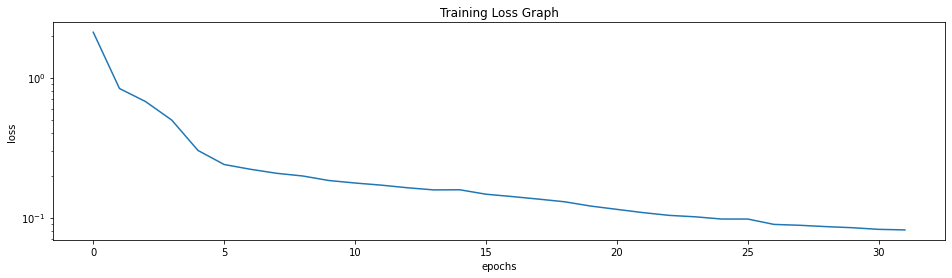

In [37]:
plt.figure(figsize=(16, 4))
plt.title("Training Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.yscale("log")
plt.plot(SAVED_MODEL["loss_history"])
plt.show()

In [38]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C71,C72,C73,C74,C75,C76,C77,C78,C79,attack
0,2020-07-07 15:00:00,402.70947,12.0,10,51.95007,-1.0189,-1.86768,789.76508,28.03162,688,...,0.0,1.34293,10.89290,34.88770,12.26196,380.31683,386.26666,32.59527,5.6330,0
1,2020-07-07 15:00:01,402.81174,12.0,10,51.96533,-1.2637,-1.86768,789.13147,28.02301,648,...,0.0,1.34216,10.80512,34.88770,12.26196,380.02747,386.30286,32.59527,5.4158,0
2,2020-07-07 15:00:02,402.76062,12.0,10,51.96533,-1.5398,-1.86768,785.81653,28.02993,616,...,0.0,1.34369,10.80029,34.88770,12.26196,381.52850,389.73883,32.59527,5.5532,0
3,2020-07-07 15:00:03,402.81174,12.0,10,51.98822,-1.6212,-1.86768,785.42438,28.02993,584,...,0.0,1.34445,10.80579,34.88770,12.26196,382.08911,388.94311,32.59527,5.7833,0
4,2020-07-07 15:00:04,402.91394,12.0,10,51.90429,-1.5631,-1.86768,782.99249,28.02990,552,...,0.0,1.34293,10.81415,34.90295,12.26196,383.44543,389.72082,32.59527,6.0309,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43196,2020-07-08 02:59:56,397.08661,12.0,10,66.58325,-1.2052,-1.83716,786.93738,28.03250,0,...,0.0,1.35971,16.19496,35.22338,12.01019,390.13672,394.91107,31.81634,5.2977,0
43197,2020-07-08 02:59:57,397.18887,12.0,10,66.58325,-0.9256,-1.83716,783.44989,28.02304,0,...,0.0,1.35971,16.23927,35.23864,12.01019,390.24518,397.35248,31.81634,5.3188,0
43198,2020-07-08 02:59:58,397.13776,12.0,10,66.58325,-0.7843,-1.83716,784.86780,28.02814,0,...,0.0,1.35818,16.20675,35.23864,12.01019,390.46222,396.70142,31.81634,5.1800,0
43199,2020-07-08 02:59:59,397.34222,12.0,10,66.58325,-0.7646,-1.83716,785.51416,28.02294,0,...,0.0,1.35818,16.17168,35.25391,12.01019,391.78241,397.73218,31.81634,4.8763,0


In [39]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])  # Data Scaling
# VALIDATION_DF = sc.fit_transform(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])    # Data Scaling by MinMaxScaler
# VALIDATION_DF = sc.fit_transform(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])    # Data Scaling by Normalizer

In [40]:
boundary_check(VALIDATION_DF)

(True, True, False)

In [41]:
HAI_DATASET_VALIDATION = HaiDataset(
    VALIDATION_DF_RAW[TIMESTAMP_FIELD], VALIDATION_DF, attacks=VALIDATION_DF_RAW[ATTACK_FIELD]
)
HAI_DATASET_VALIDATION[0]

  0%|          | 0/43112 [00:00<?, ?it/s]

# of valid windows: 43112


{'attack': 0.0,
 'ts': '2020-07-07 15:01:29',
 'given': tensor([[0.4516, 0.0000, 0.0000,  ..., 0.5798, 0.5271, 0.4014],
         [0.4526, 0.0000, 0.0000,  ..., 0.5799, 0.5271, 0.3234],
         [0.4521, 0.0000, 0.0000,  ..., 0.5927, 0.5271, 0.3727],
         ...,
         [0.5267, 0.0000, 0.0000,  ..., 0.3193, 0.5271, 0.3745],
         [0.5257, 0.0000, 0.0000,  ..., 0.3134, 0.5271, 0.4363],
         [0.5252, 0.0000, 0.0000,  ..., 0.3089, 0.5271, 0.5319]]),
 'answer': tensor([5.2717e-01, 0.0000e+00, 0.0000e+00, 1.6201e-01, 2.4634e-01, 3.0731e-04,
         4.7660e-01, 5.1151e-01, 1.1574e-03, 1.5182e-01, 4.9051e-01, 5.5063e-01,
         2.8699e-01, 0.0000e+00, 4.4413e-01, 4.3588e-01, 2.4863e-02, 0.0000e+00,
         0.0000e+00, 3.4310e-01, 0.0000e+00, 0.0000e+00, 7.5772e-01, 6.8562e-01,
         0.0000e+00, 3.7939e-01, 2.5223e-01, 0.0000e+00, 3.9106e-01, 2.5138e-02,
         9.9257e-01, 3.4135e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 4.1100e-01, 4.6915e-01

In [42]:
def inference(dataset, model, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].cuda()
            answer = batch["answer"].cuda()
            guess = model(given)
            ts.append(np.array(batch["ts"]))
            dist.append(torch.abs(answer - guess).cpu().numpy())
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(batch_size))
            
    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )

Inference 함수는 데이터를 순차적으로 보면서 모델이 예측한 값과 실제 값의 차를 구해서 기록함

In [43]:
%%time
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_VALIDATION, MODEL, BATCH_SIZE)

CPU times: user 4.1 s, sys: 14.9 ms, total: 4.11 s
Wall time: 4.1 s


In [44]:
CHECK_DIST.shape

(43112, 79)

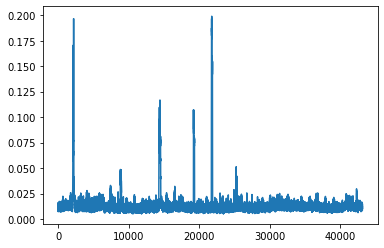

In [45]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)
plt.plot(ANOMALY_SCORE)

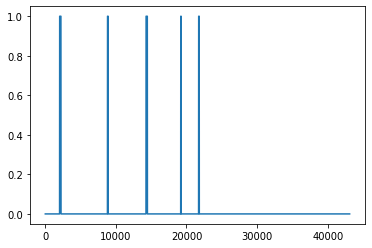

In [46]:
plt.plot(CHECK_ATT)

In [47]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

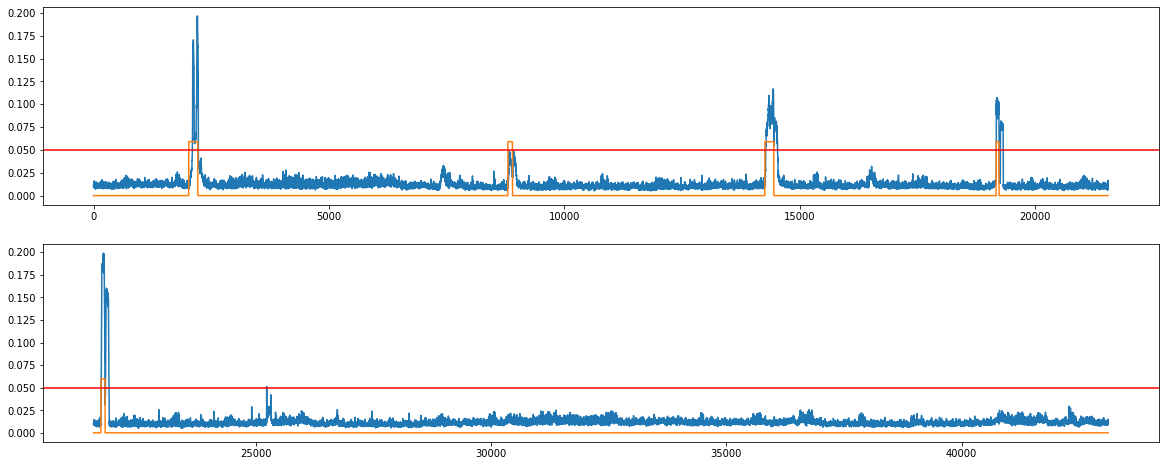

In [48]:
THRESHOLD = 0.05
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=2, THRESHOLD=THRESHOLD)

주황색 선은 Abnormal Operation 동작 부분을 나타내고, 파란색 선은 Anomaly Score (모델과 실제 데이터의 오차 크기)를 나타냅니다. Abnormal Operation 동작 부분에서 Anomaly Score (오차 크기) 가 큰 것으로 보이고 있습니다.
임의이 Threshold(빨간색 선)가 넘어갈 경우 Abnormal Operation으로 간주하고 Abnormal은 1로 정상은 0으로 구분할 수 있습니다.

In [49]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

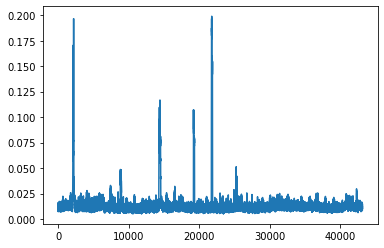

In [50]:
plt.plot(ANOMALY_SCORE)

In [51]:
THRESHOLD = 0.05

In [52]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (43112,))

In [53]:
ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold = 0.05)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0]), (43201,))

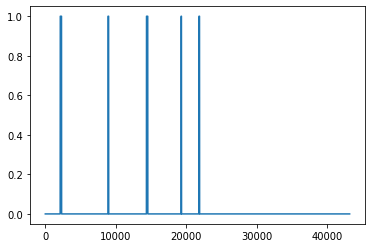

In [54]:
plt.plot(ATTACK_LABELS)

In [55]:
def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [56]:
%%time
FINAL_LABELS = fill_blank(CHECK_TS, LABELS, np.array(VALIDATION_DF_RAW[TIMESTAMP_FIELD]))
FINAL_LABELS.shape

CPU times: user 5.3 s, sys: 19 ms, total: 5.32 s
Wall time: 5.32 s


(43201,)

In [57]:
ATTACK_LABELS.shape[0] == FINAL_LABELS.shape[0]

True

In [58]:
TaPR = etapr.evaluate(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.853 (TaP: 0.963, TaR: 0.766)
# of detected anomalies: 4
Detected anomalies: ['1', '3', '4', '5']


In [59]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-09 15:00:00,384.30737,12.0,10,70.35980,-1.6171,-1.79901,774.20752,28.02385,136,...,936.58447,0.0,1.35437,13.97231,35.22338,12.02545,293.51129,283.92651,32.0,6.5059
1,2020-07-09 15:00:01,384.30737,12.0,10,70.35980,-1.7606,-1.79901,772.58758,28.02730,136,...,940.93317,0.0,1.35437,13.93358,35.20813,12.02545,292.67938,283.36591,32.0,6.3079
2,2020-07-09 15:00:02,384.20517,12.0,10,70.35980,-1.7606,-1.80664,772.58758,28.02730,136,...,936.58447,0.0,1.35513,13.95248,35.20813,12.02545,291.90179,282.93189,32.0,6.3079
3,2020-07-09 15:00:03,384.25626,12.0,10,70.35980,-1.7814,-1.79901,777.48810,28.02905,136,...,933.54034,0.0,1.35513,13.89971,35.20813,12.02545,291.59430,282.06378,32.0,6.1203
4,2020-07-09 15:00:04,384.20517,12.0,10,70.35980,-1.7370,-1.79901,778.42212,28.03169,136,...,944.41223,0.0,1.35437,13.94603,35.20813,12.02545,289.87628,283.67334,32.0,5.9543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92396,2020-07-31 12:29:56,420.08923,12.0,10,48.31848,-0.8706,97.19238,786.54382,28.03253,232,...,824.82147,100.0,1.35666,9.62203,36.47460,11.78894,357.27722,361.14728,32.0,6.2809
92397,2020-07-31 12:29:57,420.08923,12.0,10,48.31848,-0.7498,97.19238,784.07184,28.03598,224,...,823.51697,100.0,1.35513,9.48747,36.47460,11.78894,357.29529,359.84521,32.0,6.3602
92398,2020-07-31 12:29:58,420.24258,12.0,10,48.31848,-0.6076,97.19238,786.83881,28.02642,208,...,824.82147,100.0,1.35666,9.57787,36.48986,11.78894,357.27722,360.60474,32.0,6.3742
92399,2020-07-31 12:29:59,420.24258,12.0,10,48.31848,-0.4618,97.19238,786.66138,28.03341,200,...,833.51904,100.0,1.35513,9.56291,36.48986,11.78894,357.80170,357.42188,32.0,6.2864


In [60]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TEST_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,0.273715,0.0,0.0,0.828325,0.225882,0.000999,0.318761,0.333825,0.010417,0.139867,...,0.677723,0.0,0.317842,0.452044,0.236483,0.944440,0.225971,0.200389,0.26162,0.714722
1,0.273715,0.0,0.0,0.828325,0.171634,0.000999,0.300187,0.426398,0.010417,0.137445,...,0.680584,0.0,0.317842,0.450701,0.230344,0.944440,0.223121,0.198499,0.26162,0.650106
2,0.272825,0.0,0.0,0.828325,0.166747,0.000930,0.298514,0.434738,0.010417,0.137227,...,0.678007,0.0,0.318290,0.451229,0.229791,0.944440,0.220223,0.196880,0.26162,0.644285
3,0.273182,0.0,0.0,0.828325,0.158478,0.000992,0.353980,0.482056,0.010417,0.190063,...,0.675769,0.0,0.318335,0.449470,0.229736,0.944440,0.218893,0.193823,0.26162,0.583093
4,0.272773,0.0,0.0,0.828325,0.174269,0.000998,0.370123,0.556914,0.010417,0.266280,...,0.682626,0.0,0.317891,0.450884,0.229731,0.944440,0.212932,0.198888,0.26162,0.523348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92396,0.619520,0.0,0.0,0.073426,0.532147,0.998079,0.476720,0.581066,0.017489,0.358745,...,0.596406,1.0,0.319337,0.285888,0.790598,0.083339,0.466152,0.485809,0.26162,0.622130
92397,0.619561,0.0,0.0,0.073426,0.581096,0.998079,0.446527,0.680775,0.016853,0.386044,...,0.595956,1.0,0.318439,0.281450,0.790543,0.083339,0.466370,0.482229,0.26162,0.658390
92398,0.620899,0.0,0.0,0.073426,0.639210,0.998079,0.474916,0.436791,0.015748,0.453718,...,0.596761,1.0,0.319252,0.284110,0.796619,0.083339,0.466330,0.484406,0.26162,0.666539
92399,0.621033,0.0,0.0,0.073426,0.699587,0.998079,0.475741,0.598077,0.015116,0.563381,...,0.602505,1.0,0.318431,0.283862,0.797227,0.083339,0.468106,0.474004,0.26162,0.638988


In [61]:
boundary_check(TEST_DF)

(True, True, False)

In [62]:
HAI_DATASET_TEST = HaiDataset(
    TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, attacks=None
)
HAI_DATASET_VALIDATION[0]

  0%|          | 0/358715 [00:00<?, ?it/s]

# of valid windows: 358448


{'attack': 0.0,
 'ts': '2020-07-07 15:01:29',
 'given': tensor([[0.4516, 0.0000, 0.0000,  ..., 0.5798, 0.5271, 0.4014],
         [0.4526, 0.0000, 0.0000,  ..., 0.5799, 0.5271, 0.3234],
         [0.4521, 0.0000, 0.0000,  ..., 0.5927, 0.5271, 0.3727],
         ...,
         [0.5267, 0.0000, 0.0000,  ..., 0.3193, 0.5271, 0.3745],
         [0.5257, 0.0000, 0.0000,  ..., 0.3134, 0.5271, 0.4363],
         [0.5252, 0.0000, 0.0000,  ..., 0.3089, 0.5271, 0.5319]]),
 'answer': tensor([5.2717e-01, 0.0000e+00, 0.0000e+00, 1.6201e-01, 2.4634e-01, 3.0731e-04,
         4.7660e-01, 5.1151e-01, 1.1574e-03, 1.5182e-01, 4.9051e-01, 5.5063e-01,
         2.8699e-01, 0.0000e+00, 4.4413e-01, 4.3588e-01, 2.4863e-02, 0.0000e+00,
         0.0000e+00, 3.4310e-01, 0.0000e+00, 0.0000e+00, 7.5772e-01, 6.8562e-01,
         0.0000e+00, 3.7939e-01, 2.5223e-01, 0.0000e+00, 3.9106e-01, 2.5138e-02,
         9.9257e-01, 3.4135e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 4.1100e-01, 4.6915e-01

In [63]:
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_TEST, MODEL, BATCH_SIZE)

In [64]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

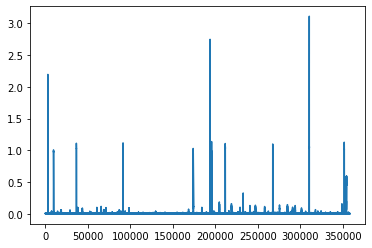

In [65]:
plt.plot(ANOMALY_SCORE)

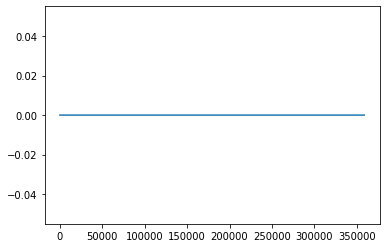

In [66]:
plt.plot(CHECK_ATT)

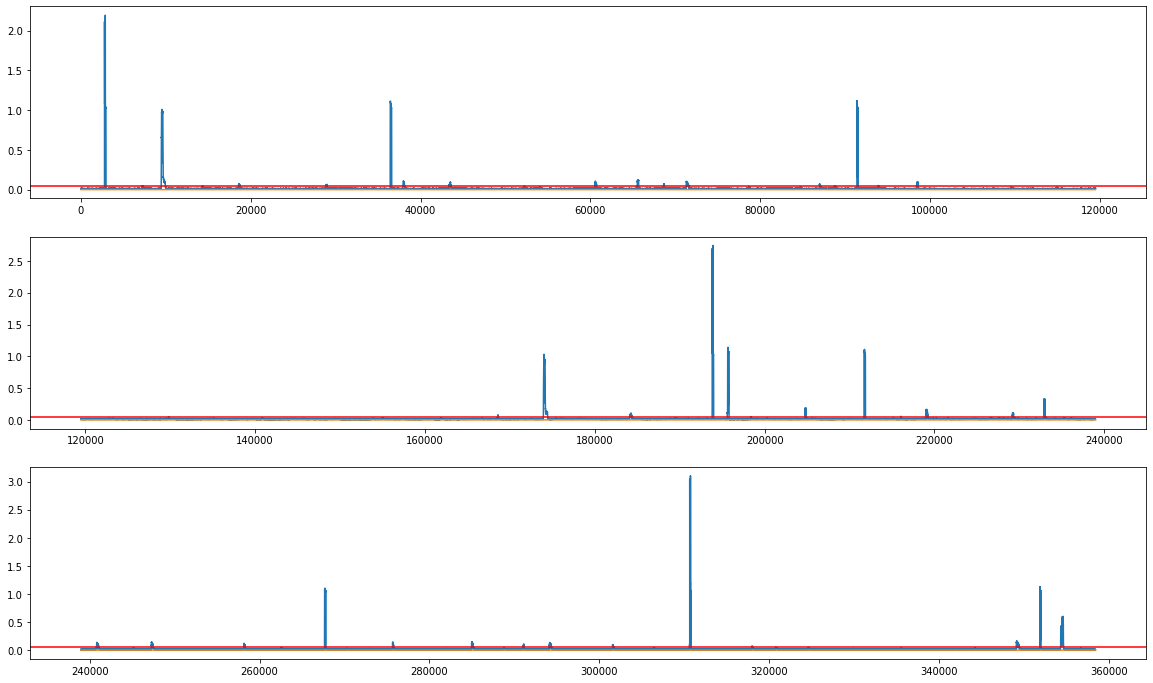

In [67]:
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=3, THRESHOLD=THRESHOLD)

In [68]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (358448,))

In [69]:
submission = pd.read_csv('data/sample_submission.csv')
submission.index = submission['time']
submission.loc[CHECK_TS,'attack'] = LABELS
submission

,time,attack
time,,
2020-07-09 15:00:00,2020-07-09 15:00:00,0.0
2020-07-09 15:00:01,2020-07-09 15:00:01,0.0
2020-07-09 15:00:02,2020-07-09 15:00:02,0.0
2020-07-09 15:00:03,2020-07-09 15:00:03,0.0
2020-07-09 15:00:04,2020-07-09 15:00:04,0.0
...,...,...
2020-07-31 12:29:56,2020-07-31 12:29:56,0.0
2020-07-31 12:29:57,2020-07-31 12:29:57,0.0
2020-07-31 12:29:58,2020-07-31 12:29:58,0.0


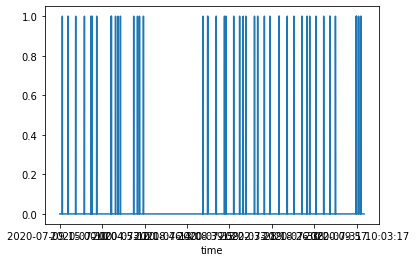

In [85]:
submission["attack"].plot()

In [70]:
submission.to_csv('baseline.csv', index=False)

In [71]:
from google.colab import files
files.download('baseline.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>